### VAE(Variational Autoencoder) is a powerful tool in manifold visualization and generate new samples mimicing the data, here we investigate training a VAE on different datasets and compare them with the original fitting.

In [139]:
import sklearn
import numpy as np
import pandas as pd
import json
import rpy2
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.python.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras import regularizers,initializers
from tensorflow.python.keras.layers import Lambda, Input, Dense, Dropout,GaussianNoise,Lambda,Flatten,Activation,concatenate
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam,Adamax,Adadelta,Adagrad,RMSprop,SGD
from tensorflow.python.keras.models import Model

In [48]:
dataA_ = pd.read_csv('A_data.csv', sep = ' ')
dataB_ = pd.read_csv('B_data.csv', sep = ' ')
whole_data = pd.concat([dataA_, dataB_], axis = 0)

In [50]:
[n_A, n_1] = dataB_.shape
[n_B, n_1] = dataA_.shape

In [91]:
#####
#Variational Autoencoder for the manifold extraction:
def VAE_DR(original_dim, inter_dim, latent_dim, Name = 'No.1'):
    input_shape = (original_dim, )
    inputs = Input(shape = input_shape, name = 'encoder_input' + Name)
    
    #Two layers' vae:
    x = Dense(inter_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
             kernel_initializer = keras.initializers.glorot_uniform())(inputs)
    x = Dropout(0.4)(x)
    z_mean = Dense(latent_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                  name = 'z_mean' + Name, kernel_initializer = keras.initializers.glorot_uniform())(x)
    z_log_var = Dense(latent_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                     kernel_initializer = keras.initializers.glorot_uniform())(x)
    ##
    #Sampling the latent space:
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    z = Lambda(sampling, output_shape = (latent_dim), name = 'Sampling_layer' + Name)([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name = 'Encoder'+ Name)
    ######
    #Decoder part:
    latent_inputs = Input(shape = (latent_dim, ), name = 'Z' + Name)
    x = Dense(inter_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3), 
              kernel_initializer = keras.initializers.glorot_uniform())(latent_inputs)
    x = Dropout(0.2)(x)
    output = Dense(original_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                   kernel_initializer = keras.initializers.glorot_uniform())(x)
    ##
    decoder = Model(latent_inputs, output, name = 'decoder'+ Name)
    outputs = decoder(encoder(inputs)[2])
    VAE_model = Model(inputs, outputs, name = 'vae_mlp' + Name)
    #
    models = (encoder, decoder)
    #####
    #Add loss:
    recon_loss = losses.mean_squared_error(outputs, inputs)
    recon_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis = -1)
    kl_loss *= -0.5
    #The VAE loss consists of reconstruction loss and kl loss(kl divergence 
    #between the approximate posterior and true posterior)
    vae_loss = K.mean(recon_loss + kl_loss)
    VAE_model.add_loss(vae_loss)
    OPTIM = Adam(lr = 5e-5)
    VAE_model.compile(optimizer = OPTIM)
    return encoder, decoder, VAE_model
    

In [101]:
#VAE training for the first population:
encoder1, decoder1, VAE_model1 = VAE_DR(n_1, 40, 2)
#Train the model:
callbacks = [EarlyStopping(monitor='val_loss', patience = 80)]
VAE_model1.fit(dataA_, epochs = 4000, callbacks = callbacks, validation_split = 0.2, shuffle = True)
#Apply the generative nature to generate new samples for this cell population:
[z_mean1, z_log_var1, latent_generation1] = encoder1.predict(dataA_)
random_gene1 = np.random.normal(0, 1, [100, 2])
generation1 = decoder1.predict(random_gene1)

W0730 22:49:00.686506 4599326144 training_utils.py:1101] Output decoderNo.1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoderNo.1.


Train on 2018 samples, validate on 505 samples
Epoch 1/4000
2018/2018 [==============================] - 2s 1ms/sample - loss: 18314281.7365 - val_loss: 2070.9698
Epoch 2/4000
2018/2018 [==============================] - 0s 148us/sample - loss: 199524848.3262 - val_loss: 2067.6615
Epoch 3/4000
2018/2018 [==============================] - 0s 141us/sample - loss: 112034.1653 - val_loss: 2067.6004
Epoch 4/4000
2018/2018 [==============================] - 0s 145us/sample - loss: 160396.8326 - val_loss: 2064.5529
Epoch 5/4000
2018/2018 [==============================] - 0s 143us/sample - loss: 92282.9130 - val_loss: 2062.4004
Epoch 6/4000
2018/2018 [==============================] - 0s 146us/sample - loss: 139553.9357 - val_loss: 2061.3286
Epoch 7/4000
2018/2018 [==============================] - 0s 143us/sample - loss: 100319.9072 - val_loss: 2058.6122
Epoch 8/4000
2018/2018 [==============================] - 0s 141us/sample - loss: 1582411.0033 - val_loss: 2055.2036
Epoch 9/4000
2018/2018

2018/2018 [==============================] - 0s 134us/sample - loss: 13105.5227 - val_loss: 1909.3112
Epoch 72/4000
2018/2018 [==============================] - 0s 138us/sample - loss: 13706.8686 - val_loss: 1906.8245
Epoch 73/4000
2018/2018 [==============================] - 0s 132us/sample - loss: 15239.6629 - val_loss: 1903.7622
Epoch 74/4000
2018/2018 [==============================] - 0s 130us/sample - loss: 21176.1759 - val_loss: 1902.4180
Epoch 75/4000
2018/2018 [==============================] - 0s 133us/sample - loss: 13002.7685 - val_loss: 1899.7691
Epoch 76/4000
2018/2018 [==============================] - 0s 133us/sample - loss: 13066.7606 - val_loss: 1897.7586
Epoch 77/4000
2018/2018 [==============================] - 0s 129us/sample - loss: 15360.5258 - val_loss: 1896.4858
Epoch 78/4000
2018/2018 [==============================] - 0s 134us/sample - loss: 12996.3172 - val_loss: 1893.3301
Epoch 79/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 129

2018/2018 [==============================] - 0s 140us/sample - loss: 11174.0713 - val_loss: 1597.4160
Epoch 142/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 11152.5365 - val_loss: 1586.4971
Epoch 143/4000
2018/2018 [==============================] - 0s 134us/sample - loss: 16471.7766 - val_loss: 1574.6970
Epoch 144/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 1355568.0024 - val_loss: 1574.0573
Epoch 145/4000
2018/2018 [==============================] - 0s 137us/sample - loss: 10953.6008 - val_loss: 1562.4808
Epoch 146/4000
2018/2018 [==============================] - 0s 129us/sample - loss: 10744.8737 - val_loss: 1552.9542
Epoch 147/4000
2018/2018 [==============================] - 0s 143us/sample - loss: 10836.1876 - val_loss: 1541.8417
Epoch 148/4000
2018/2018 [==============================] - 0s 140us/sample - loss: 10644.6186 - val_loss: 1531.2276
Epoch 149/4000
2018/2018 [==============================] - 0s 135us/sample -

2018/2018 [==============================] - 0s 151us/sample - loss: 7087.5500 - val_loss: 1155.0614
Epoch 212/4000
2018/2018 [==============================] - 0s 147us/sample - loss: 7092.1826 - val_loss: 1154.8833
Epoch 213/4000
2018/2018 [==============================] - 0s 143us/sample - loss: 7048.4052 - val_loss: 1152.2228
Epoch 214/4000
2018/2018 [==============================] - 0s 157us/sample - loss: 7023.0530 - val_loss: 1151.0747
Epoch 215/4000
2018/2018 [==============================] - 0s 146us/sample - loss: 7015.7392 - val_loss: 1149.7505
Epoch 216/4000
2018/2018 [==============================] - 0s 160us/sample - loss: 7052.5990 - val_loss: 1147.4184
Epoch 217/4000
2018/2018 [==============================] - 0s 184us/sample - loss: 12291.7623 - val_loss: 1146.0430
Epoch 218/4000
2018/2018 [==============================] - 0s 194us/sample - loss: 6990.1417 - val_loss: 1145.0123
Epoch 219/4000
2018/2018 [==============================] - 0s 161us/sample - loss: 69

2018/2018 [==============================] - 0s 145us/sample - loss: 6691.2486 - val_loss: 1119.6510
Epoch 282/4000
2018/2018 [==============================] - 0s 141us/sample - loss: 6638.0093 - val_loss: 1122.6980
Epoch 283/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 6662.7663 - val_loss: 1121.2508
Epoch 284/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 6690.1761 - val_loss: 1120.6477
Epoch 285/4000
2018/2018 [==============================] - 0s 134us/sample - loss: 6628.1238 - val_loss: 1118.5738
Epoch 286/4000
2018/2018 [==============================] - 0s 133us/sample - loss: 6674.9386 - val_loss: 1125.3475
Epoch 287/4000
2018/2018 [==============================] - 0s 137us/sample - loss: 6669.7229 - val_loss: 1124.1072
Epoch 288/4000
2018/2018 [==============================] - 0s 136us/sample - loss: 6611.1413 - val_loss: 1120.2612
Epoch 289/4000
2018/2018 [==============================] - 0s 137us/sample - loss: 666

In [102]:
#VAE training for the first population:
encoder2, decoder2, VAE_model2 = VAE_DR(n_1, 40, 2)
#Train the model:
callbacks = [EarlyStopping(monitor='val_loss', patience = 80)]
VAE_model1.fit(dataB_, epochs = 4000, callbacks = callbacks, validation_split = 0.2, shuffle = True)
#Apply the generative nature to generate new samples for this cell population:
[z_mean2, z_log_var2, latent_generation2] = encoder1.predict(dataB_)
random_gene2 = np.random.normal(0, 1, [500, 2])
generation2 = decoder2.predict(random_gene2)


W0730 22:50:39.707083 4599326144 training_utils.py:1101] Output decoderNo.1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoderNo.1.


Train on 1803 samples, validate on 451 samples
Epoch 1/4000
1803/1803 [==============================] - 1s 624us/sample - loss: 8720.1931 - val_loss: 1298.3568
Epoch 2/4000
1803/1803 [==============================] - 0s 146us/sample - loss: 6887.1527 - val_loss: 1249.7127
Epoch 3/4000
1803/1803 [==============================] - 0s 140us/sample - loss: 6767.8590 - val_loss: 1223.0977
Epoch 4/4000
1803/1803 [==============================] - 0s 133us/sample - loss: 6758.2637 - val_loss: 1205.9449
Epoch 5/4000
1803/1803 [==============================] - 0s 133us/sample - loss: 6671.2082 - val_loss: 1195.9492
Epoch 6/4000
1803/1803 [==============================] - 0s 136us/sample - loss: 6671.3262 - val_loss: 1187.3016
Epoch 7/4000
1803/1803 [==============================] - 0s 136us/sample - loss: 116120.5442 - val_loss: 1177.2950
Epoch 8/4000
1803/1803 [==============================] - 0s 132us/sample - loss: 6676.9700 - val_loss: 1171.2452
Epoch 9/4000
1803/1803 [===============

Epoch 72/4000
1803/1803 [==============================] - 0s 165us/sample - loss: 5678.9214 - val_loss: 1041.6088
Epoch 73/4000
1803/1803 [==============================] - 0s 165us/sample - loss: 5655.5589 - val_loss: 1032.1739
Epoch 74/4000
1803/1803 [==============================] - 0s 163us/sample - loss: 5623.7725 - val_loss: 1032.3936
Epoch 75/4000
1803/1803 [==============================] - 0s 142us/sample - loss: 5562.0532 - val_loss: 1028.6798
Epoch 76/4000
1803/1803 [==============================] - 0s 138us/sample - loss: 5545.6607 - val_loss: 1022.8637
Epoch 77/4000
1803/1803 [==============================] - 0s 133us/sample - loss: 5501.3327 - val_loss: 1024.3284
Epoch 78/4000
1803/1803 [==============================] - 0s 138us/sample - loss: 5455.1191 - val_loss: 1021.4182
Epoch 79/4000
1803/1803 [==============================] - 0s 141us/sample - loss: 5456.5408 - val_loss: 1018.7788
Epoch 80/4000
1803/1803 [==============================] - 0s 146us/sample - los

1803/1803 [==============================] - 0s 142us/sample - loss: 4261.3292 - val_loss: 899.8500
Epoch 144/4000
1803/1803 [==============================] - 0s 140us/sample - loss: 4269.7524 - val_loss: 896.9177
Epoch 145/4000
1803/1803 [==============================] - 0s 144us/sample - loss: 4236.4656 - val_loss: 898.7381
Epoch 146/4000
1803/1803 [==============================] - 0s 135us/sample - loss: 4242.6508 - val_loss: 898.1720
Epoch 147/4000
1803/1803 [==============================] - 0s 150us/sample - loss: 4297.4079 - val_loss: 905.1452
Epoch 148/4000
1803/1803 [==============================] - 0s 154us/sample - loss: 4262.4310 - val_loss: 900.9572
Epoch 149/4000
1803/1803 [==============================] - 0s 156us/sample - loss: 4254.8883 - val_loss: 894.5385
Epoch 150/4000
1803/1803 [==============================] - 0s 143us/sample - loss: 32237.9785 - val_loss: 888.0134
Epoch 151/4000
1803/1803 [==============================] - 0s 149us/sample - loss: 4249.9191 

1803/1803 [==============================] - 0s 148us/sample - loss: 4069.5279 - val_loss: 898.6050
Epoch 215/4000
1803/1803 [==============================] - 0s 135us/sample - loss: 4072.6816 - val_loss: 898.5158
Epoch 216/4000
1803/1803 [==============================] - 0s 147us/sample - loss: 4383.7031 - val_loss: 902.3806
Epoch 217/4000
1803/1803 [==============================] - 0s 139us/sample - loss: 4004.9953 - val_loss: 894.5369
Epoch 218/4000
1803/1803 [==============================] - 0s 134us/sample - loss: 4067.4871 - val_loss: 890.6924
Epoch 219/4000
1803/1803 [==============================] - 0s 150us/sample - loss: 4027.2651 - val_loss: 897.1960
Epoch 220/4000
1803/1803 [==============================] - 0s 148us/sample - loss: 4029.7040 - val_loss: 895.9490
Epoch 221/4000
1803/1803 [==============================] - 0s 138us/sample - loss: 4064.5425 - val_loss: 896.2721
Epoch 222/4000
1803/1803 [==============================] - 0s 137us/sample - loss: 4018.8727 -

1803/1803 [==============================] - 0s 137us/sample - loss: 3838.5286 - val_loss: 926.5137
Epoch 286/4000
1803/1803 [==============================] - 0s 142us/sample - loss: 3825.5342 - val_loss: 914.4949


In [146]:
#Sampling the data from two generative models:
n_samp = 900
random_gene1 = np.random.normal(0, 1, [n_samp, 2])
generation1 = decoder1.predict(random_gene1)
random_gene2 = np.random.normal(0, 1, [n_samp, 2])
generation2 = decoder2.predict(random_gene2)

#Visualize the data:
new_sample = np.concatenate([generation1, generation2, dataA_, dataB_], axis = 0)
new_sample = preprocessing.scale(new_sample, axis = 1)

In [147]:
grp_info = np.concatenate([np.repeat(0, n_samp),np.repeat(1, n_samp), np.repeat(2, n_A), np.repeat(3, n_B)])

In [153]:
#Visualize by TSNE:
tsne1 = TSNE(n_components = 2, perplexity = 50)
X_embedd1 = tsne1.fit_transform(new_sample)

(-103.6291640298052, 95.70735006496145, -90.62250518513811, 109.37011718464987)

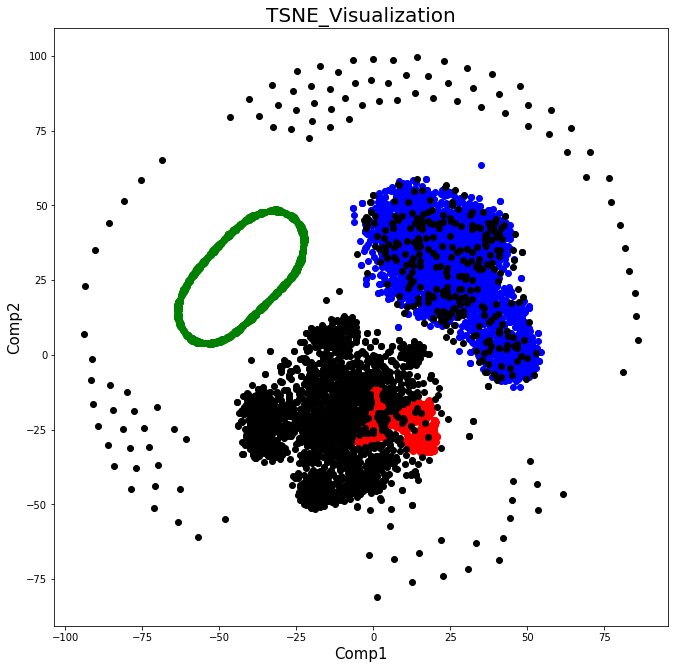

In [156]:
fig, ax = plt.subplots(figsize = (11, 11))
red = grp_info == 0
green = grp_info == 1
blue = grp_info == 2
black = grp_info == 3
ax.scatter(X_embedd1[red, 0], X_embedd1[red, 1], c = "r")
ax.scatter(X_embedd1[green, 0], X_embedd1[green, 1], c = "g")
ax.scatter(X_embedd1[blue, 0], X_embedd1[blue, 1], c = 'b')
ax.scatter(X_embedd1[black, 0], X_embedd1[black, 1], c = 'k' )
ax.set_title('TSNE_Visualization', fontsize = 20)
ax.set_xlabel('Comp1', fontsize = 15)
ax.set_ylabel('Comp2', fontsize = 15)
plt.axis('tight')

(-0.6551105333504704,
 0.5023355903699194,
 -0.6572872315911139,
 0.4404585052364569)

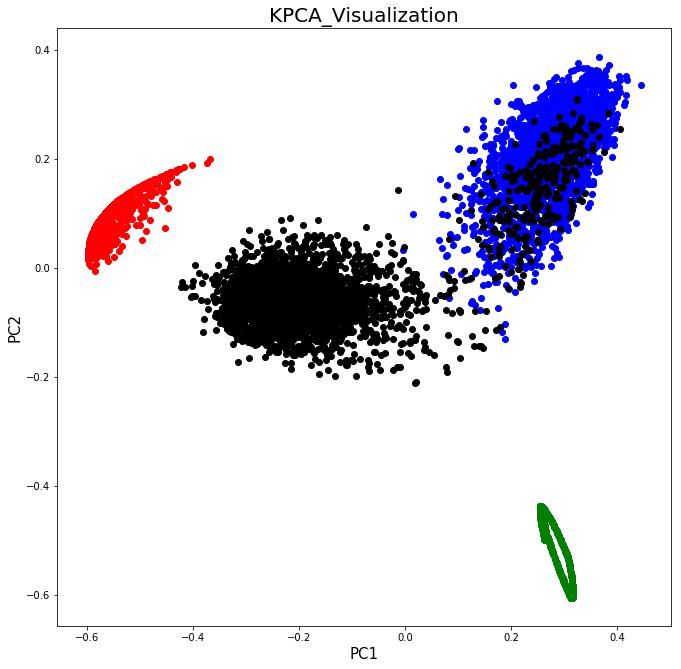

In [155]:
#Kernel PCA:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_embedd2 = kpca.fit_transform(new_sample)
fig, ax = plt.subplots(figsize = (11, 11))
red = grp_info == 0
green = grp_info == 1
blue = grp_info == 2
black = grp_info == 3
ax.scatter(X_embedd2[red, 0], X_embedd2[red, 1], c = "r")
ax.scatter(X_embedd2[green, 0], X_embedd2[green, 1], c = "g")
ax.scatter(X_embedd2[blue, 0], X_embedd2[blue, 1], c = 'b')
ax.scatter(X_embedd2[black, 0], X_embedd2[black, 1], c = 'k' )
ax.set_title('KPCA_Visualization', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
plt.axis('tight')

In [ ]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
Isomap(n_)
